<a href="https://colab.research.google.com/github/hj56775/dlibforbeauty/blob/main/%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pwd

/content


In [2]:
%cd drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [3]:
!ls

 03_01_autoencoder_train.ipynb	  OBS_ASOS_DD_20201207220648_TEST.csv
 AE.py				  __pycache__
'callbacks (1).py'		  study_cnn.ipynb
 callbacks.py			  Untitled
 DailyDelhiClimateTest.csv	  Untitled0.ipynb
 DailyDelhiClimateTrain.csv	  Untitled1.ipynb
 dlib_beauty.ipynb		  Untitled2.ipynb
 images				  Untitled3.ipynb
 오토인코더.ipynb		 'Untitled3.ipynb의 사본'
 MLPDelhiClimateAnalysis.ipynb	  weights
 OBS_ASOS_DD_20201207220648.csv


In [4]:
import os

In [5]:
import numpy as np
import dlib
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab.patches import cv2_imshow
from callbacks import CustomCallback, step_decay_schedule

In [6]:
from tensorflow import keras
mnist = keras.datasets.mnist

(X_train,y_train), (X_test, y_test) = mnist.load_data()

In [7]:
X_train = X_train.astype('float32') / 255.
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.astype('float32') / 255.
X_test = X_test.reshape(X_test.shape + (1,))

In [8]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model 
import tensorflow as tf
import numpy as np

input_dim=(28,28,1)
filter=[32,64,64,64]
stride=[1,2,2,1]
encoder_input = Input(shape=input_dim, name='input')

x = encoder_input

for i in range(4):
    conv_layer = Conv2D(
        filters = filter[i]
        , kernel_size = 3
        , strides = stride[i]
        ,padding = 'same'
        , name = 'conv' + str(i)
        )

    x = conv_layer(x)
    x = LeakyReLU()(x)


shape_before_flattening = K.int_shape(x)[1:]

x = Flatten()(x)
encoder_output=Dense(2,name='encoder_output')(x)


encoder=Model(encoder_input,encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0     

In [9]:
shape_before_flattening

(7, 7, 64)

In [10]:
filter=[64,64,32,1]
stride=[1,2,2,1]
decoder_input = Input(shape=2, name='decoder_input')

x = Dense(np.prod(shape_before_flattening))(decoder_input)
x=Reshape(shape_before_flattening)(x)

for i in range(4):
    conv_t_layer = Conv2DTranspose(
        filters = filter[i]
        , kernel_size = 3
        , strides = stride[i]
        ,padding = 'same'
        , name = 'decoder_conv_t' + str(i)
        )

    x = conv_t_layer(x)

    if i <3:
      x=LeakyReLU()(x)
    else:
      x=Activation('sigmoid')(x)

decoder_output=x


decoder=Model(decoder_input,decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t0 (Conv2DTrans (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t1 (Conv2DTrans (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0   

In [11]:
X_train.shape

(60000, 28, 28, 1)

In [12]:
#오토인코더
model_input=encoder_input
model_output=decoder(encoder_output)
model=Model(model_input,model_output)

In [13]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0   

In [14]:
lr_sched = step_decay_schedule(initial_lr=0.0005, decay_factor=1, step_size=1)

In [15]:
custom_callback = CustomCallback("/content/drive/MyDrive/Colab Notebooks", 100, 0,decoder)

In [16]:
checkpoint2 = ModelCheckpoint(os.path.join("/content/drive/MyDrive/Colab Notebooks", 'weights/weights.h5'), save_weights_only = True, verbose=1)

In [17]:
callbacks_list = [checkpoint2, custom_callback, lr_sched]

In [18]:
def r_loss(y_true,y_pred):
  print(y_true,y_pred)
  return K.sqrt(K.mean(K.square(y_true-y_pred),axis=[1,2,3]))

In [19]:
#컴파일
model.compile(optimizer=Adam(lr=0.0005),loss= r_loss)

In [20]:
model.fit(   
    X_train
    , X_train
    , batch_size =32
    , shuffle = True
    , epochs = 10
    , initial_epoch = 0
    , callbacks = callbacks_list
)

Epoch 1/10
Tensor("IteratorGetNext:1", shape=(32, 28, 28, 1), dtype=float32) Tensor("model_2/model_1/activation/Sigmoid:0", shape=(32, 28, 28, 1), dtype=float32)
Tensor("IteratorGetNext:1", shape=(32, 28, 28, 1), dtype=float32) Tensor("model_2/model_1/activation/Sigmoid:0", shape=(32, 28, 28, 1), dtype=float32)
1875/1875 [==============================] - 11s 5ms/step - loss: 0.2514

Epoch 00001: saving model to /content/drive/MyDrive/Colab Notebooks/weights/weights.h5
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2090

Epoch 00002: saving model to /content/drive/MyDrive/Colab Notebooks/weights/weights.h5
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2050

Epoch 00003: saving model to /content/drive/MyDrive/Colab Notebooks/weights/weights.h5
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2019

Epoch 00004: saving model to /content/drive/MyDrive/Colab Notebooks/weights/weights.h5
Epoch 5/10
18

In [21]:
example_idx = np.random.choice(range(len(X_test)), 5000)
example_images = X_test[example_idx]

In [22]:
#for i in range(5000):
  #img = example_images[i].squeeze()

In [23]:
reconst_images=model.predict(example_images)

#for i in range(5000):
    #img1 = reconst_images[i].squeeze()

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm

In [27]:
z_points = encoder.predict(example_images)

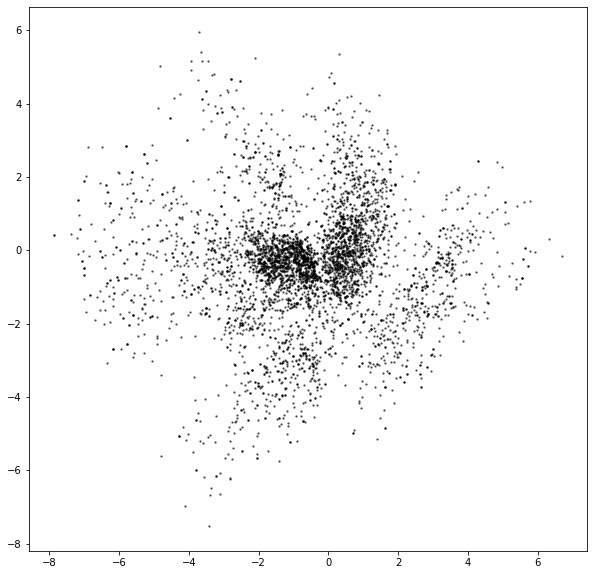

In [28]:
grid_size = 15
figsize = 10

example_labels = y_test[example_idx]
plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)

plt.show()

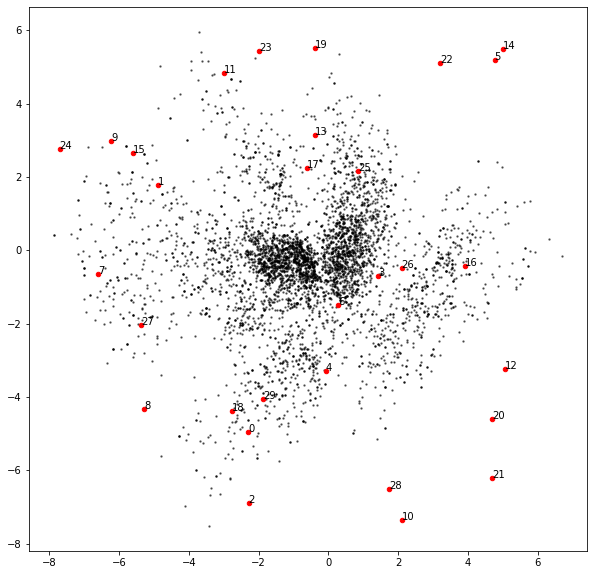

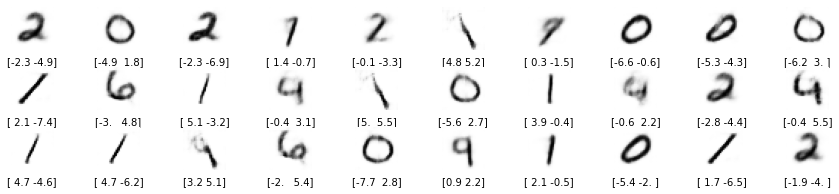

In [32]:

grid_size = 15
figsize = 10

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)

grid_size = 10
grid_depth = 3
figsize = 15

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

x = np.random.uniform(min_x, max_x, size = grid_size * grid_depth)
y = np.random.uniform(min_y, max_y, size = grid_size * grid_depth)
z_grid = np.array(list(zip(x, y)))
reconst=decoder.predict(z_grid)
for i in range(30):
  plt.scatter(z_grid[i, 0] , z_grid[i, 1], c='red', alpha=1, s=20)
  plt.text(z_grid[i, 0] , z_grid[i, 1],i)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

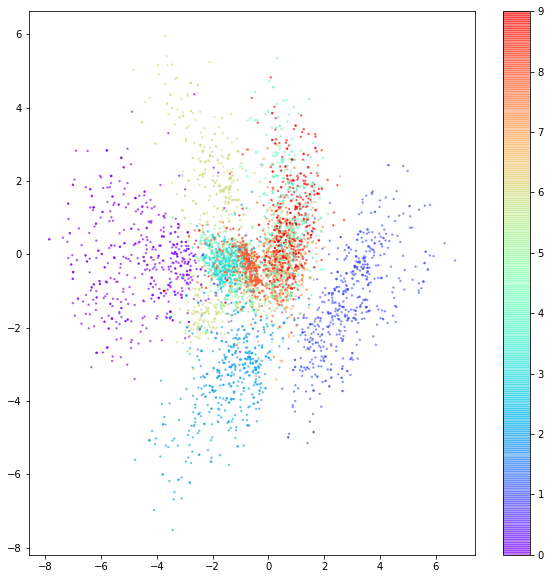

In [33]:
figsize = 10

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], cmap='rainbow', c=example_labels, alpha=0.5, s=2)
plt.colorbar()

plt.show()

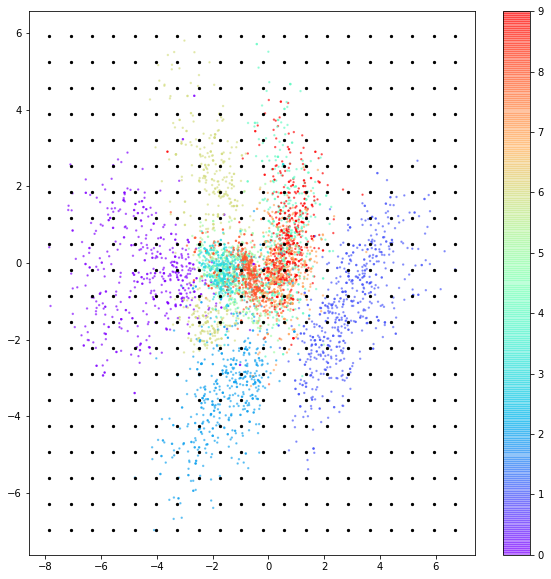

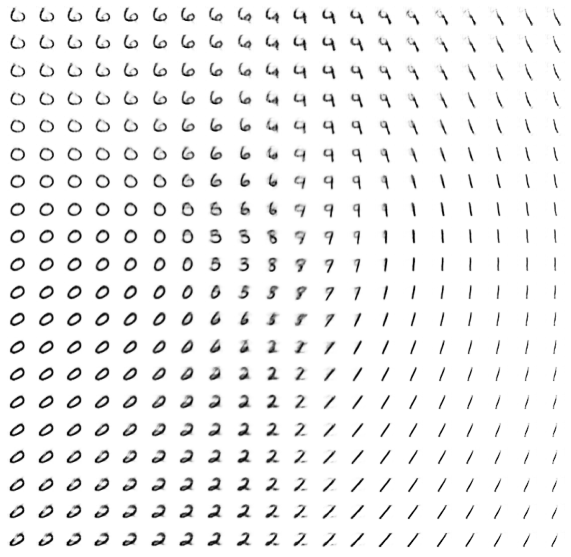

In [43]:
n_to_show = 5000
grid_size = 20

example_idx = np.random.choice(range(len(X_test)), n_to_show)
example_images = X_test[example_idx]
example_labels = y_test[example_idx]

z_points = encoder.predict(example_images)

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c=example_labels
            , alpha=0.5, s=2)
plt.colorbar()

#x = norm.ppf(np.linspace(0.05, 0.95, 10))
#y = norm.ppf(np.linspace(0.05, 0.95, 10))
x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), grid_size)
y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y) # 격자점 찍어주기
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=5)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')